### Import libraries

In [16]:
from datetime import datetime
import keras
from keras import backend as K
from keras.layers import Concatenate, Lambda, LSTM, Reshape, Dense, Embedding, Average, Reshape, Flatten, Input
from keras.models import Model 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import zipfile

### Download dataset
Downloading the dataset using the function provided in the assignment

In [3]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

# Uncomment if you need to dowload the dataset
#download_data('dataset')

### Preprocessing data
We are preprosseing like this.... FILL OUT

#### Create dataframes

In [4]:
#create a dataframe for the training data 
train_df = pd.read_csv('./dataset/train_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})

#create a dataframe for the validation data 
val_df = pd.read_csv('./dataset/val_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})

#create a dataframe for the test data 
test_df = pd.read_csv('./dataset/test_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})

#### Clean text data

In [5]:

"""train_df = pd.read_csv('./dataset/train_pairs.csv', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})
train_df["Evidence"] = train_df["Evidence"].str.split(pat = "\t")
train_df["evidenceID"]=train_df["Evidence"].str[0]
train_df["Evidence"]=train_df["Evidence"].str[1]
train_df["Label"] = train_df["Label"].replace({'SUPPORTS': 1, 'REFUTES': 0})

train_df"""

'train_df = pd.read_csv(\'./dataset/train_pairs.csv\', skipinitialspace=True, usecols=["Claim","Evidence","ID","Label"]).rename(columns={"ID": "claimID"})\ntrain_df["Evidence"] = train_df["Evidence"].str.split(pat = "\t")\ntrain_df["evidenceID"]=train_df["Evidence"].str[0]\ntrain_df["Evidence"]=train_df["Evidence"].str[1]\ntrain_df["Label"] = train_df["Label"].replace({\'SUPPORTS\': 1, \'REFUTES\': 0})\n\ntrain_df'

#### Extract y values for train, val and test

In [6]:
y_train = np.array(train_df['Label'])
y_val = np.array(val_df['Label'])
y_test = np.array(test_df['Label'])

### Tokenize and padding of data

In [7]:
# The tokenizer will have an index 1 for OOV words. A lot of words in test and val will be 1.
tokenizer = Tokenizer(oov_token=1)

tokenizer.fit_on_texts(train_df["Claim"])
tokenizer.fit_on_texts(train_df["Evidence"])

In [8]:
# Find max sentence lenght for evidence
MAX_SEQ_LEN = np.max([len(text.split()) for text in train_df["Evidence"]])

In [9]:
def textToTensor(tokenizer, max_len, text):
    '''
        Converts text to tensors by converting the words into the correct indexes. 
        Then padds the tensors with 0 vlaues
    '''
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences=seq, maxlen=max_len)
    return padded

In [10]:
claim_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["Claim"])
evidence_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["Evidence"])

claim_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["Claim"])
evidence_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["Evidence"])

claim_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["Claim"])
evidence_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["Evidence"])

In [11]:
# Find size of vocabulary
VOCABULARY_SIZE = len(tokenizer.word_index) + 1

#### Convert lables into integers

In [12]:
y_train = np.array([1 if x=='SUPPORTS' else 0 for x in train_df["Label"]])
y_val = np.array([1 if x=='SUPPORTS' else 0 for x in val_df["Label"]])
y_test = np.array([1 if x=='SUPPORTS' else 0 for x in test_df["Label"]])

### Create model

In [13]:
def create_model(max_tokens, vocab_size, embedding_dimension, sentence_embedding_type=1, merge_type=1):
    '''
        Creates keras model for classification.
        Inputs: 
            max_tokens (int): Max length of a text sequence
            vocab_size (int): Size of the vocabulary
            embedding_dimension (int): The dimention of the embedding vectors
            sentence_embedding_type (int): Defines which sentence embedding to use
            merge_type (int): Defines which merging function to use
    '''   

    #-------------------------- Input layer ------------------------------------------------------------
    claims_input = Input(shape=(max_tokens, ))
    evidence_input = Input(shape=(max_tokens, ))
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Word embedding ------------------------------------------------------------
    claims_embedding = Embedding(vocab_size, embedding_dimension, name='WordEmbedding_claims')(claims_input)
    evidence_embedding = Embedding(vocab_size, embedding_dimension, name='WordEmbedding_evidence')(evidence_input)
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Sentence embedding -------------------------------------------------------
    if sentence_embedding_type==1:
        # Encode token sequences via a RNN and take the last state as the sentence embedding.
        claims_sentence_embedding = LSTM(embedding_dimension, return_sequences=False, name='SentenceEmbedding_claims')(claims_embedding)
        evidence_sentence_embedding = LSTM(embedding_dimension, return_sequences=False, name='SentenceEmbedding_evidence')(evidence_embedding)
    elif sentence_embedding_type==2:
        # Encode token sequences via a RNN and average all the output states.

        # Put return_sequences True to get output from all hidden states
        claims_sentence_embedding = LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_claims')(claims_embedding)
        evidence_sentence_embedding = LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_evidence')(evidence_embedding)
        
        # Take average of outputs
        claims_sentence_embedding = K.mean(claims_sentence_embedding, axis=1)
        evidence_sentence_embedding = K.mean(evidence_sentence_embedding, axis=1)

    elif sentence_embedding_type==3:
        # Encode token sequences via a simple MLP layer.
        num = embedding_dimension*max_tokens
        # Reshape 3d vector to 2d
        claims_sentence_embedding = Reshape((num,), input_shape=(max_tokens, embedding_dimension))(claims_embedding)
        evidence_sentence_embedding = Reshape((num,), input_shape=(max_tokens, embedding_dimension))(evidence_embedding)

        # Send into dense layer
        claims_sentence_embedding = Dense(num, name='SentenceEmbedding_claims')(claims_sentence_embedding)
        evidence_sentence_embedding = Dense(num, name='SentenceEmbedding_evidence')(evidence_sentence_embedding)
   
    elif sentence_embedding_type==4:
        # Compute the sentence embedding as the mean of its token embeddings (bag of vectors).
        claims_sentence_embedding = K.mean(claims_embedding, axis=1)
        evidence_sentence_embedding = K.mean(evidence_embedding, axis=1)
    else:
        raise Exception("Sentence embedding type must be an integer between 1 and 4")
    #------------------------------------------------------------------------------------------------------------
    

    #-------------------------- Extension with cosine similarity -----------------------------------------------
    # Calulate cosine similarity
    # Returns list of cosine similarities for each evidence claim pair
    cosine_loss = tf.keras.losses.CosineSimilarity(axis=-1, reduction=tf.keras.losses.Reduction.NONE)
    cosine_similarity = cosine_loss(claims_sentence_embedding, evidence_sentence_embedding)

    # Expand dimention to get tensor on shape (embedding_dimension, 1)
    cosine_similarity = Lambda(lambda x: K.expand_dims(x, axis=1))(cosine_similarity)

    # Concatenate tensors and get them on shape (batch_size, embedding_dim + 1)
    claims_sentence_embedding = Concatenate(axis=-1)([claims_sentence_embedding, cosine_similarity])
    evidence_sentence_embedding = Concatenate(axis=-1)([evidence_sentence_embedding, cosine_similarity])
    #------------------------------------------------------------------------------------------------------------

    #------------------------------------- Merging --------------------------------------------------------------
    if merge_type == 1:
        # Concatenate
        merged = Concatenate(axis=1)([claims_sentence_embedding, evidence_sentence_embedding])
    elif merge_type == 2:
        # Sum
        merged = Add([claims_sentence_embedding, evidence_sentence_embedding])
    elif merge_type == 3:
        # Mean
        merged = Average(axis=1)([claims_sentence_embedding, evidence_sentence_embedding])
    else:
        raise Exception("Merge type must be an integer between 1 and 3")
    #------------------------------------------------------------------------------------------------------------

    #------------------------------------- Classification --------------------------------------------------------------
    out = (Dense(1, activation='sigmoid'))(merged)
    #------------------------------------------------------------------------------------------------------------

    model = Model(inputs=[claims_input, evidence_input], outputs=[out])

    return model

#### Create model with sentence embedding #1 and merging #1

In [14]:
model = create_model(MAX_SEQ_LEN, VOCABULARY_SIZE, 50)
model.summary()

2021-11-29 16:09:58.703172: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 237)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 237)]        0           []                               
                                                                                                  
 WordEmbedding_claims (Embeddin  (None, 237, 50)     1790000     ['input_1[0][0]']                
 g)                                                                                               
                                                                                                  
 WordEmbedding_evidence (Embedd  (None, 237, 50)     1790000     ['input_2[0][0]']            

### Train model

In [18]:
model.compile(loss='mse',
              optimizer='Adam',
              metrics=['acc'])
history = model.fit(x=[claim_train, evidence_train], y=y_train, batch_size=100, epochs=10, validation_data=([claim_val, evidence_val], y_val))

Epoch 1/10
1218/1218 [==============================] - 306s 249ms/step - loss: 0.1323 - acc: 0.8241 - val_loss: 0.1845 - val_acc: 0.7244
Epoch 2/10
1218/1218 [==============================] - 307s 252ms/step - loss: 0.0985 - acc: 0.8672 - val_loss: 0.1806 - val_acc: 0.7352
Epoch 3/10
1218/1218 [==============================] - 320s 263ms/step - loss: 0.0819 - acc: 0.8911 - val_loss: 0.1893 - val_acc: 0.7344
Epoch 4/10
 775/1218 [==================>...........] - ETA: 1:57 - loss: 0.0668 - acc: 0.9134

### Save model

In [25]:
def save_model(model, sentence_embedding_type=1, merge_type=1, dir='models'):
    '''
        Saves model naming it according to sentence embedding merge type and time stamp.
    '''
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
    model_name = f'model_SE{sentence_embedding_type}_MT{merge_type}_{dt_string}'
    path = f'{dir}/{model_name}'
    model.save(path)


In [26]:
save_model(model, 1, 1)

INFO:tensorflow:Assets written to: models/model_SE1_MT1_29_11_2021_16:28:38/assets


INFO:tensorflow:Assets written to: models/model_SE1_MT1_29_11_2021_16:28:38/assets


### Prediction
Calcualte the predictions for the test set

In [ ]:
def prediction(model: keras.Model, x, predicting_info):
    '''Call the models prediction function'''
    predictions = model.predict(x, **predicting_info)
    return predictions

In [ ]:
predictions = prediction(model, [claim_test, evidence_test], {'batch_size': 100})
predictions = np.rint(predictions)

## Evaluation

### Multi-input classification evaluation

#### Defining plotting functions

In [ ]:
def plot_accuracy(model_callback):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_confusion_matrix(confusion_matrix):

    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

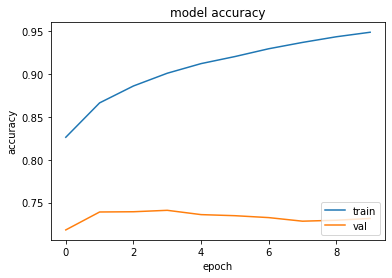

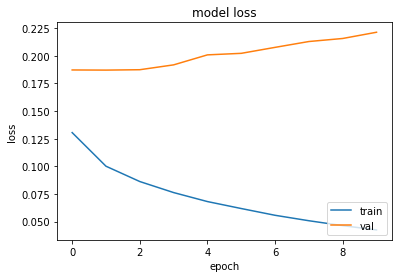

In [ ]:
plot_accuracy(history)
plot_loss(history)

In [27]:
def evaluation(predictions):
    '''
        Function for plotting the confusion_matrix
        Inputs:
            predicitons: Predicitons from a keras model
    '''
    print(classification_report(y_test, predictions))
    print(accuracy_score(y_test, predictions))
    cf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cf_matrix)

In [28]:
evaluation(predictions)

NameError: name 'predictions' is not defined

### Claim verification evaluation

In [ ]:
def make_claims_dict():
    """
    Makes a dictionary with claimID as key and 
    a list of the index for every evidence 
    corresponding to the claim as value
    """
    claims = {}
    t = test_df.groupby("claimID")
    for name, group in t:
        claims[name] = list(group.index)
    return claims

In [ ]:
claims_dict = make_claims_dict()

In [ ]:
def majority_pred(predictions):
    """
    Find predictions based on majority voting
    """
    majority = []

    for i in range(len(claim_test)):
        claim_id = np.array(test_df['claimID'])[i]
        support = 0
        defutes = 0
        for evidence in claims_dict[claim_id]:
            if predictions[evidence] == 1:
                support += 1
            else:
                defutes += 1
        if support > defutes:
            majority.append(1.0)
        else:
            majority.append(0.0)
    return majority

In [ ]:
majority_predictions = majority_pred(predictions)

              precision    recall  f1-score   support

           0       0.76      0.62      0.69      3583
           1       0.68      0.81      0.74      3606

    accuracy                           0.72      7189
   macro avg       0.72      0.72      0.71      7189
weighted avg       0.72      0.72      0.71      7189

0.715537626930032


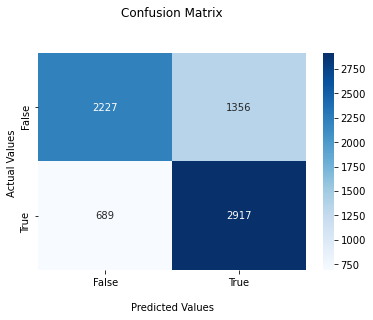

In [ ]:
evaluation(majority_predictions)